<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part10/P10_CH02_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Localization & 성능개선
- Oxford-IIIT Pet dataset은 37종의 개, 고양이로 구성된 dataset입니다.
- 파일은 하나의 압축파일로 구성되며 압축파일은 다음과 같이 구성되어 있습니다.
- 모든 데이터의 이름은 class_name.(확장자)로 구성되어 있으며 class_name의 첫 알파벳이 대문자이면 '고양이', 소문자이면 '개'입니다.

1. images
  - image 데이터들이 포함되어 있음
  - 확장자는 모두 jpg임
  - RGB이미지 외에도 Gray scale이나 RGBA 이미지도 함께 포함되어 있음
2. annotations/xmls
  - localization을 위한 bounding-box 위치 정보가 포함되어 있음
  - image의 width, height 등 기타 다른 정보도 함께 저장되어 있음
  - 확장자는 모두 xml임
3. annotations/trimaps
  - segmentation을 위한 segmentation map이 포함되어 있음
  - 확장자는 모두 png임
  

- localization / multitask learning 성능향상 방법

# 1.데이터 다운로드 / 전처리

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import xml.etree.ElementTree as et
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import gdown

In [2]:
data_url = "https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0"

In [3]:
gdown.download(data_url, 'oxford_pet.zip', quiet=False)
!unzip -q oxford_pet.zip -d oxford_pet

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
100%|██████████| 811M/811M [00:09<00:00, 81.7MB/s]


replace oxford_pet/annotations/._trimaps? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# directory 정보
## image data : images -> jpg -> n_images
## bounding box : annotations/xmls -> xml -> n_bboxes

cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
bbox_dir = os.path.join(data_dir, 'annotations','xmls')

In [5]:
# image file 개수
image_files =[fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] =='.jpg']
n_images = len(image_files)
print(n_images)

7378


In [6]:
# localization을 위한 bounding box 정보가 있는 xml file의 수 확인
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] =='.xml']
n_bboxes = len(bbox_files)
print(n_bboxes)

3685


- head ROI가 있는 이미지가 3686개밖에 없으므로 이미지도 3686개만 사용

## 데이터 확인하기
- bounding boxsms matplotlib.patches 의 Rectangle 이용
- 좌측 상단좌표 (x,y) -> rect_x, rect_y
- width, height -> rect_w, rect_h


<ipython-input-7-d1b47114f7e2>:8: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './object/bndbox/xmin'
  xmin = float(tree.find('/object/bndbox/xmin').text)
<ipython-input-7-d1b47114f7e2>:9: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './object/bndbox/ymin'
  ymin = float(tree.find('/object/bndbox/ymin').text)
<ipython-input-7-d1b47114f7e2>:10: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './object/bndbox/xmax'
  xmax = float(tree.find('/object/bndbox/xmax').text)
<ipython-input-7-d1b47114f7e2>:11: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './object/bndbox/ymax'
  ymax = float(t

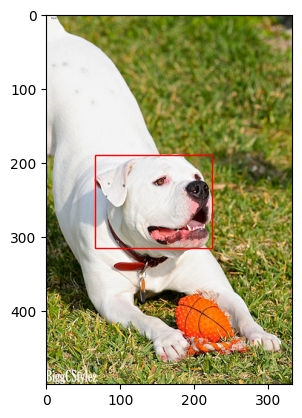

In [7]:
rnd_idx = random.randint(0, n_bboxes-1)

bbox_name = bbox_files[rnd_idx]
bbox_path = os.path.join(bbox_dir, bbox_name)

tree = et.parse(bbox_path)

xmin = float(tree.find('/object/bndbox/xmin').text)
ymin = float(tree.find('/object/bndbox/ymin').text)
xmax = float(tree.find('/object/bndbox/xmax').text)
ymax = float(tree.find('/object/bndbox/ymax').text)


rect_x = xmin
rect_y = ymin
rect_w = xmax - xmin
rect_h = ymax - ymin


# Abyssinian_1.xml -> Abyssinisan_1.jpg
fname = os.path.splitext(bbox_name)[0] + '.jpg'

fpath = os.path.join(image_dir, fname)
image = Image.open(fpath)
image = np.array(image)

rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill = False, color = 'red')
plt.axes().add_patch(rect)
plt.imshow(image)
plt.show()

## RGB외의 data 삭제
- RGB 아닌 image, bounding box file 삭제
- PIL.Image mode 사용

In [8]:
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    bbox_file = os.path.splitext(image_file)[0] + '.xml'
    bbox_path = os.path.join(bbox_dir, bbox_file)
    image = Image.open(image_path)

    if image.mode != 'RGB':
        print(image_file, image.mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(image_path)
        try :
            os.remove(bbox_path)
        except FileNotFoundError:
            pass

In [9]:
# image file 개수
image_files =[fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] =='.jpg']
n_images = len(image_files)
print(n_images)


7378


In [10]:
#bbox_files 개수
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] =='.xml']
n_bboxes = len(bbox_files)
print(n_bboxes)

3685


# 2.tfrecord 파일 만들기

- protocol buffer 형태의 binary file 형태
- image와 boundingnox 정보를 tfrecord file 형태로 저장
https://www.tensorflow.org/tutorials/load_data/tfrecord?hl=ko

## train/ val data 나누기
- 224x224 resize 하여 저장
- train 3000 val 685개 사용
- test는 인터넷에서 임의의 이미지로 사용

In [11]:
# 필요한 상수들
IMG_SIZE = 224
N_DATA = 3685
N_TRAIN = 3000
N_VAL = N_DATA - N_TRAIN

- bounding box file 중 random하게 3000개 뽑아서 train 으로 사용, 나머지 val로 사용
- bounding box file과 같은 이름을 가진 image file도 똑같이 나눔
- 이를 위해 image file, xml file의 list를 활용해 index를 random으로 3000개 뽑아서 활용

In [12]:
shuffle_list = list(range(N_DATA))

random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

In [13]:
val_idx_list

[1153,
 1802,
 1699,
 235,
 804,
 735,
 2115,
 198,
 1316,
 1116,
 3010,
 263,
 810,
 3210,
 2007,
 1941,
 2185,
 3537,
 2827,
 2942,
 2172,
 2151,
 3260,
 109,
 152,
 2634,
 2985,
 2764,
 1431,
 1781,
 201,
 933,
 2488,
 1044,
 99,
 3355,
 1761,
 1477,
 1641,
 559,
 2436,
 3661,
 2608,
 1045,
 310,
 2363,
 2631,
 2689,
 630,
 2014,
 305,
 442,
 3672,
 2432,
 2999,
 3620,
 2493,
 3417,
 659,
 3027,
 847,
 2095,
 2279,
 1214,
 1027,
 1315,
 2036,
 814,
 3112,
 1686,
 1549,
 2300,
 28,
 684,
 1833,
 3213,
 2722,
 572,
 971,
 3050,
 576,
 3167,
 1585,
 3648,
 2534,
 3062,
 2575,
 67,
 2337,
 714,
 440,
 389,
 1550,
 2362,
 632,
 1036,
 2276,
 567,
 3135,
 3276,
 1835,
 1840,
 615,
 3060,
 1544,
 596,
 3219,
 363,
 2744,
 2832,
 1964,
 2984,
 1785,
 3489,
 2705,
 612,
 873,
 112,
 754,
 3192,
 3618,
 1702,
 537,
 3377,
 3592,
 1658,
 3437,
 3558,
 1569,
 3320,
 147,
 830,
 3001,
 437,
 2202,
 3218,
 3054,
 3512,
 1446,
 3662,
 780,
 3204,
 1601,
 3139,
 2380,
 2340,
 2161,
 247,
 2481,
 11

## tfrecord writer 생성
- tf.io.TFRecordWriter 사용

In [14]:
# directory 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok = True)

tfr_train_dir = os.path.join(tfr_dir, 'loc_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'loc_val.tfr')

In [15]:
# tfwriter 생성

writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [16]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))




- training data에서 image와 bounding box 정보를 하나씩 읽어서 tfrecord writer를 이용하여 tfrecord file에 write합니다.
- 이 때, image는 bytes feature 형태로 저장합니다. (위 3개 함수 중 맨 위 함수 사용)
- bounding box 정보는 bounding box의 center 좌표(x, y)와 width, height 이 4개의 숫자를 각각 floating point로 저장합니다.
- 이 때, x, y, width, height 값을 image의 width와 height로 나누어 모두 0에서 1 사이의 값이 되도록 합니다.
- 추가로 개를 0번 class, 고양이를 1번 class로 하여 class label도 tfrecord 파일에 같이 저장합니다(int type 사용)
- 이 class 정보는 뒤에서 multi-task learning을 활용할 때 사용하게 됩니다.
- 개는 파일명의 첫 알파벳이 소문자이고, 고양이는 대문자이기 때문에 이를 이용하여 구분할 수 있습니다.
- ((중요)) tfrecord file을 저장할 때 feature의 key 값은 다음과 같은 이름을 사용합니다.
  - 'image': image
  - 'cls_num': 개/고양이 class 번호
  - 'x': bounding box의 center x 좌표
  - 'y': bounding box의 center y 좌표
  - 'w': bounding box의 width
  - 'h': bounding box의 height
- ((주의)) training data를 모두 tfrecord file에 write한 후에는 반드시 writer를 close 합니다.

In [17]:
for idx in train_idx_list :
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)

    tree = et.parse(bbox_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('./size/height').text)

    # bounding box 정보
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)

    ## bounding box  중심 좌표(x,y) 계산
    xc = (xmin + xmax) / 2.
    yc = (ymin + ymax) / 2.
    ### 0~1 사이로 정규화
    x = xc / width
    y = yc / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height

    # image 정보
    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    img_path = os.path.join(image_dir, image_file)
    image = Image.open(img_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()

    # class 정보
    if file_name[0].islower():
        cls_num = 0
    else:
        cls_num = 1

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(cls_num),
        'x': _float_feature(x),
        'y': _float_feature(y),
        'w': _float_feature(w),
        'h': _float_feature(h)
    }))
    writer_train.write(example.SerializeToString())

writer_train.close()

## validation용 writer 생성

In [18]:
for idx in val_idx_list :
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)

    tree = et.parse(bbox_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('./size/height').text)

    # bounding box 정보
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)

    ## bounding box  중심 좌표(x,y) 계산
    xc = (xmin + xmax) / 2.
    yc = (ymin + ymax) / 2.
    ### 0~1 사이로 정규화
    x = xc / width
    y = yc / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height

    # image 정보
    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    img_path = os.path.join(image_dir, image_file)
    image = Image.open(img_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()

    # class 정보
    if file_name[0].islower():
        cls_num = 0
    else:
        cls_num = 1

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(cls_num),
        'x': _float_feature(x),
        'y': _float_feature(y),
        'w': _float_feature(w),
        'h': _float_feature(h)
    }))
    writer_val.write(example.SerializeToString())

writer_val.close()

# 3.Image Localization 모델 작성 및 학습


In [19]:
## Hyper Parameter
N_EPOCHS = 40
N_BATCH = 40
N_VAL_BATCH = 137

learning_rate = 0.0001

## tfrecord 파일 읽기 -> train/ validation dataset 구성
- tf.data.TFRecordDataset 활용

In [20]:
def _parse_function(tfrecord_serialized):
    features = {
        'image' : tf.io.FixedLenFeature([], tf.string),
        'cls_num' : tf.io.FixedLenFeature([], tf.int64),
        'x' : tf.io.FixedLenFeature([], tf.float32),
        'y' : tf.io.FixedLenFeature([], tf.float32),
        'w' : tf.io.FixedLenFeature([], tf.float32),
        'h' : tf.io.FixedLenFeature([], tf.float32)
    }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8) # bytes로 저장해놓은거 다시 돌리기
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/ 255. # 0~1 로 변환

    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x, y, w, h], -1) # ground truth

    return image, gt


In [21]:
## train_dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size= N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH)

In [22]:
## validataion_dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(N_VAL_BATCH)

## dataset 확인

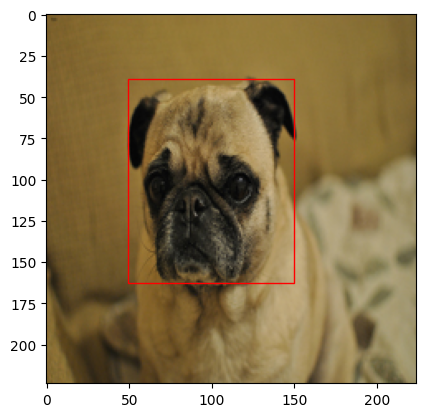

In [23]:
for image, gt in val_dataset.take(1):
    # bbox의 왼쪽 위 꼭지점 좌표를 계산
    # xmin, ymin, w, h 각각을 image size에 맞게 scaling

    x = gt[:,0]
    y = gt[:,1]
    w = gt[:,2]
    h = gt[:,3]

    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * IMG_SIZE) # 왼쪽 위 x
    rect_y = int(ymin * IMG_SIZE) # 왼쪽 위 y
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)

    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill = False, color = 'red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()


## CNN으로 Localization scratch부터 학습

In [24]:
# 간단한 CNN으로 학습

def create_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3,3), activation = 'relu', padding = 'SAME', input_shape = (IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.MaxPool2D((2,2), padding = 'SAME'))
    model.add(keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'SAME'))
    model.add(keras.layers.MaxPool2D((2,2), padding = 'SAME'))
    model.add(keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'SAME'))
    model.add(keras.layers.MaxPool2D((2,2), padding = 'SAME'))
    model.add(keras.layers.Conv2D(256, (3,3), activation = 'relu', padding = 'SAME'))
    model.add(keras.layers.MaxPool2D((2,2), padding = 'SAME'))
    model.add(keras.layers.Conv2D(256, (3,3), activation = 'relu', padding = 'SAME'))
    model.add(keras.layers.MaxPool2D((2,2), padding = 'SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation = 'relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(4, activation = 'sigmoid'))
    return model

model = create_model()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

In [ ]:
def loss_fn(y_true, y_pred):
    return keras.losses.MeanSquaredError()(y_true, y_pred)


lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = learning_rate,
    decay_steps = N_TRAIN//N_BATCH * 10 , # 10 epoch당 절반 감소
    decay_rate = 0.5,
    staircase = True # 계단식으로 떨어지게
)
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = lr_schedule), loss = loss_fn)

In [26]:
# Train

history1 = model.fit(train_dataset, epochs = N_EPOCHS, validation_data = val_dataset, verbose = 1)

Epoch 1/40
75/75 [==============================] - 19s 122ms/step - loss: 0.0239 - val_loss: 0.0235
Epoch 2/40
75/75 [==============================] - 7s 79ms/step - loss: 0.0234 - val_loss: 0.0233
Epoch 3/40
75/75 [==============================] - 8s 88ms/step - loss: 0.0232 - val_loss: 0.0232
Epoch 4/40
75/75 [==============================] - 10s 86ms/step - loss: 0.0230 - val_loss: 0.0231
Epoch 5/40
75/75 [==============================] - 10s 96ms/step - loss: 0.0228 - val_loss: 0.0228
Epoch 6/40
75/75 [==============================] - 7s 80ms/step - loss: 0.0225 - val_loss: 0.0226
Epoch 7/40
75/75 [==============================] - 8s 84ms/step - loss: 0.0225 - val_loss: 0.0227
Epoch 8/40
75/75 [==============================] - 8s 88ms/step - loss: 0.0222 - val_loss: 0.0221
Epoch 9/40
75/75 [==============================] - 7s 81ms/step - loss: 0.0219 - val_loss: 0.0219
Epoch 10/40
75/75 [==============================] - 11s 94ms/step - loss: 0.0216 - val_loss: 0.0216
Epoc

### 학습 결과 확인

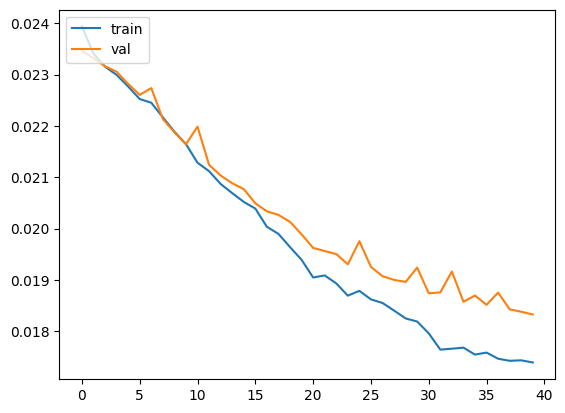

In [27]:
plt.plot(history1.history['loss'], label = 'train')
plt.plot(history1.history['val_loss'], label = 'val')

plt.legend(loc = 'upper left')
plt.show()

5/5 [==============================] - 1s 105ms/step


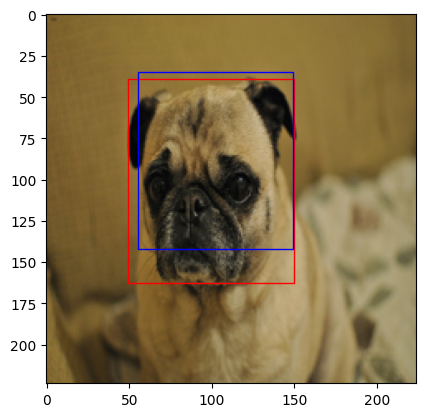

5/5 [==============================] - 0s 17ms/step


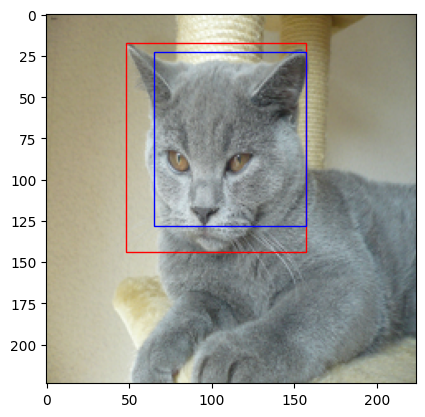

5/5 [==============================] - 0s 21ms/step


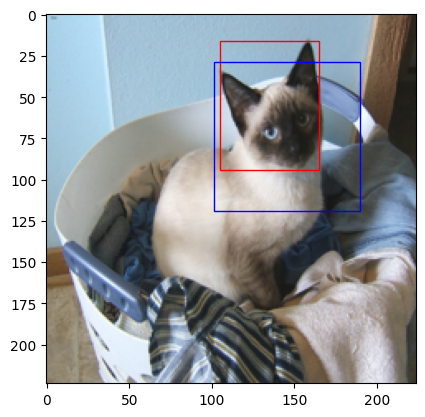

5/5 [==============================] - 0s 22ms/step


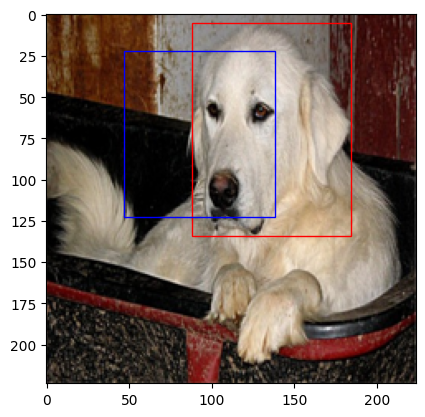

5/5 [==============================] - 0s 25ms/step


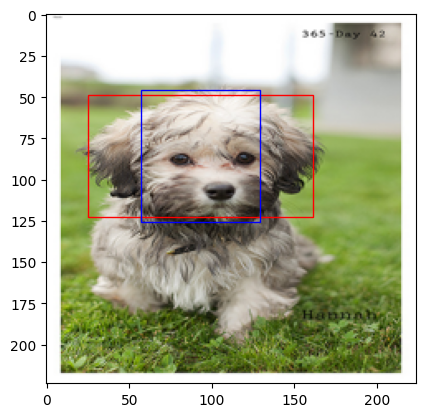

In [28]:
# 예측 bounding box와 ground truth box 를 image에 같이 표시
## 정답 빨강 box , 예측 파란색 box

idx = 0
for val_data, val_gt in val_dataset:
    # ground truth
    x = val_gt[:, 0]
    y = val_gt[:, 1]
    w = val_gt[:, 2]
    h = val_gt[:, 3]

    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE) # 왼쪽 위 x
    rect_y = int(ymin * IMG_SIZE) # 왼쪽 위 y
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)

    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill = False, color = 'red')

    # pred
    prediction = model.predict(val_data)
    pred_x = prediction[:, 0]
    pred_y = prediction[:, 1]
    pred_w = prediction[:, 2]
    pred_h = prediction[:, 3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.

    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)

    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                          fill = False, color = 'blue')

    # 이미지위에 합치기
    plt.imshow(val_data[idx])
    plt.gca().add_patch(rect)
    plt.gca().add_patch(pred_rect)
    plt.show()


### IoU 계산하기

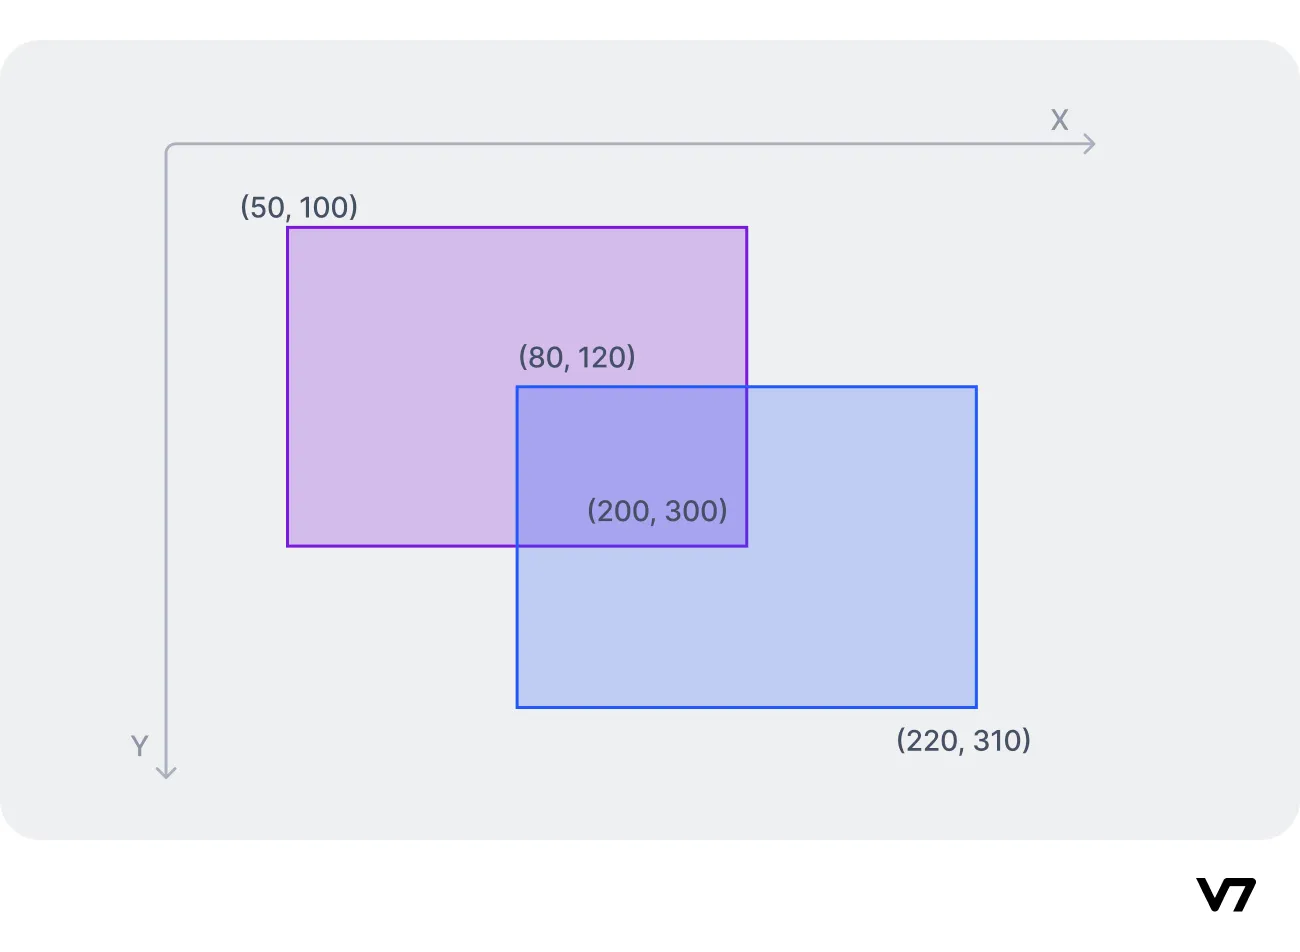

In [29]:
## IoU

avg_iou = 0
for val_data, val_gt in val_dataset:
    x = val_gt[:, 0]
    y = val_gt[:, 1]
    w = val_gt[:, 2]
    h = val_gt[:, 3]

    prediction = model.predict(val_data)
    pred_x = prediction[:, 0]
    pred_y = prediction[:, 1]
    pred_w = prediction[:, 2]
    pred_h = prediction[:, 3]
    for idx in range(N_VAL_BATCH):
        # gt bbox
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

        # pred bbox
        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

        # 아예 안겹친 경우 제외
        if xmin > pred_xmax or xmax < pred_xmin :
            continue
        if ymin > pred_ymax or ymax < pred_ymin :
            continue

        # IoU 부분 가로 세로 구하기
        w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))

        # 면적계산
        inter = w_inter * h_inter
        union = (w[idx].numpy()*h[idx].numpy() + pred_w[idx]*pred_h[idx])*IMG_SIZE *IMG_SIZE - inter

        iou = inter /union
        avg_iou += iou /N_VAL


print(f"IoU : {avg_iou}")



5/5 [==============================] - 0s 27ms/step
IoU : 0.427610912991761


## Pre - Trained MobileNetV2로 Localization 학습

In [23]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [24]:
mobilenetv2 = MobileNetV2(weights= 'imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)

In [25]:
mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [26]:
def mv2_model():
    model = tf.keras.Sequential()
    model.add(mobilenetv2)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(4, activation = 'sigmoid'))
    return model
model = mv2_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                        

In [27]:
def loss_fn(y_true, y_pred):
    return tf.keras.losses.MeanSquaredError()(y_true, y_pred)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=N_TRAIN//N_BATCH * 10,
    decay_rate=0.5,
    staircase = True)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule), loss=loss_fn)

In [28]:
hist2 = model.fit(train_dataset, epochs= 50, validation_data=val_dataset)

Epoch 1/50
75/75 [==============================] - 40s 213ms/step - loss: 0.0767 - val_loss: 0.1380
Epoch 2/50
75/75 [==============================] - 13s 164ms/step - loss: 0.0301 - val_loss: 0.1489
Epoch 3/50
75/75 [==============================] - 14s 165ms/step - loss: 0.0192 - val_loss: 0.1082
Epoch 4/50
75/75 [==============================] - 14s 172ms/step - loss: 0.0138 - val_loss: 0.1099
Epoch 5/50
75/75 [==============================] - 14s 173ms/step - loss: 0.0115 - val_loss: 0.0759
Epoch 6/50
75/75 [==============================] - 14s 166ms/step - loss: 0.0101 - val_loss: 0.0631
Epoch 7/50
75/75 [==============================] - 15s 174ms/step - loss: 0.0092 - val_loss: 0.0548
Epoch 8/50
75/75 [==============================] - 14s 174ms/step - loss: 0.0085 - val_loss: 0.0390
Epoch 9/50
75/75 [==============================] - 14s 174ms/step - loss: 0.0080 - val_loss: 0.0547
Epoch 10/50
75/75 [==============================] - 14s 174ms/step - loss: 0.0075 - val_lo

### 학습 결과 확인

5/5 [==============================] - 3s 201ms/step


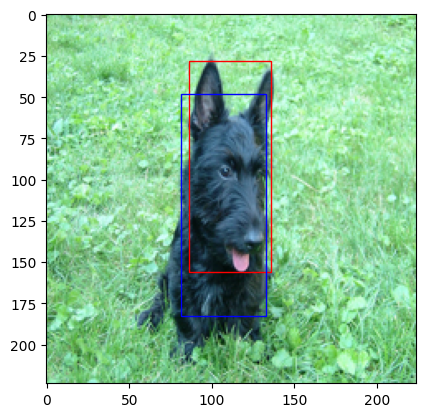

5/5 [==============================] - 0s 34ms/step


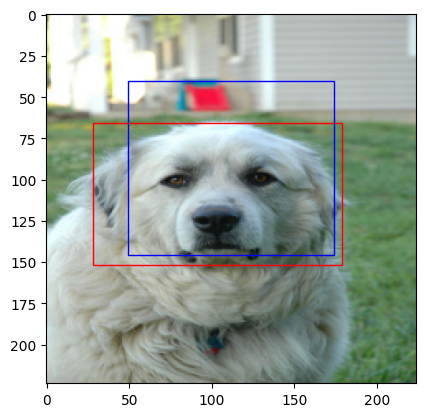

5/5 [==============================] - 0s 36ms/step


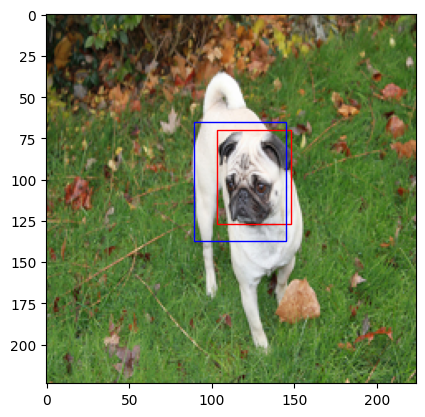

5/5 [==============================] - 0s 36ms/step


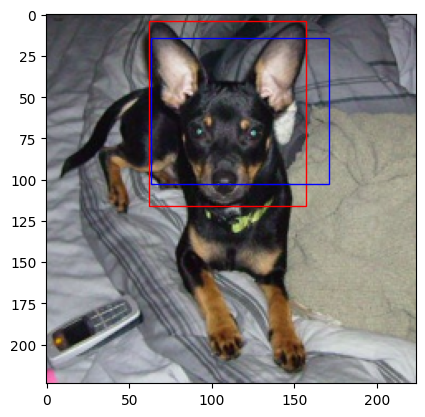

5/5 [==============================] - 0s 37ms/step


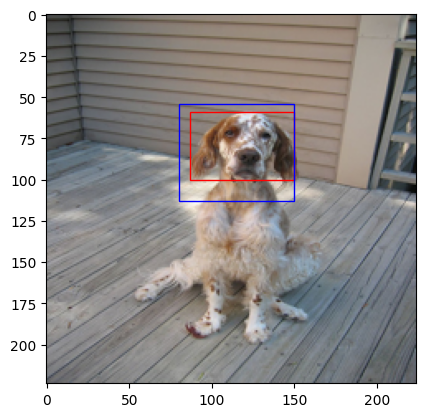

In [29]:
# 예측 bounding box와 ground truth box 를 image에 같이 표시
## 정답 빨강 box , 예측 파란색 box

idx = 0
for val_data, val_gt in val_dataset:
    # ground truth
    x = val_gt[:, 0]
    y = val_gt[:, 1]
    w = val_gt[:, 2]
    h = val_gt[:, 3]

    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE) # 왼쪽 위 x
    rect_y = int(ymin * IMG_SIZE) # 왼쪽 위 y
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)

    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill = False, color = 'red')

    # pred
    prediction = model.predict(val_data)
    pred_x = prediction[:, 0]
    pred_y = prediction[:, 1]
    pred_w = prediction[:, 2]
    pred_h = prediction[:, 3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.

    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)

    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                          fill = False, color = 'blue')

    # 이미지위에 합치기
    plt.imshow(val_data[idx])
    plt.gca().add_patch(rect)
    plt.gca().add_patch(pred_rect)
    plt.show()


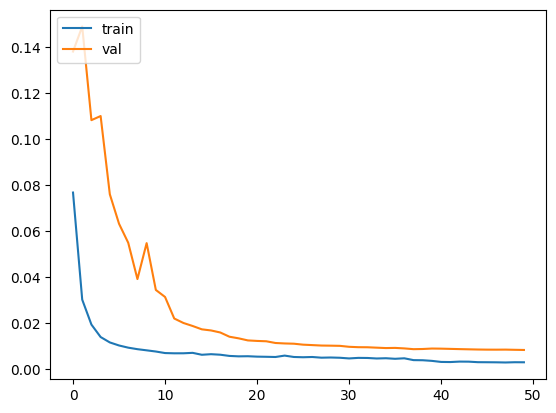

In [31]:
plt.plot(hist2.history['loss'], label = 'train')
plt.plot(hist2.history['val_loss'], label = 'val')

plt.legend(loc = 'upper left')
plt.show()

### IoU 계산하기

In [32]:
## IoU

avg_iou = 0
for val_data, val_gt in val_dataset:
    x = val_gt[:, 0]
    y = val_gt[:, 1]
    w = val_gt[:, 2]
    h = val_gt[:, 3]

    prediction = model.predict(val_data)
    pred_x = prediction[:, 0]
    pred_y = prediction[:, 1]
    pred_w = prediction[:, 2]
    pred_h = prediction[:, 3]
    for idx in range(N_VAL_BATCH):
        # gt bbox
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

        # pred bbox
        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

        # 아예 안겹친 경우 제외
        if xmin > pred_xmax or xmax < pred_xmin :
            continue
        if ymin > pred_ymax or ymax < pred_ymin :
            continue

        # IoU 부분 가로 세로 구하기
        w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))

        # 면적계산
        inter = w_inter * h_inter
        union = (w[idx].numpy()*h[idx].numpy() + pred_w[idx]*pred_h[idx])*IMG_SIZE *IMG_SIZE - inter

        iou = inter /union
        avg_iou += iou /N_VAL


print(f"IoU : {avg_iou}")



5/5 [==============================] - 0s 36ms/step
IoU : 0.47745277274363446
